##### Spoiler Alert! Spoiler Detection Project

## Train-Test-Split and Preprocessing 

In [1]:
reset -fs

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [49]:
#Disable scientific notation for floats
pd.options.display.float_format = '{:,}'.format

#Enable viewing more (in this case: all) features of a dataset
pd.set_option('display.max_columns', 500)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Load datafile
df = pd.read_hdf('data/complete_data.h5')

### Train-Test-Split

In [ ]:
# Split train, validation and test test with ratios 70% - 20% -10%
train, validation, test = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

In [ ]:
#Save validation and test sets (train set will be saved after preprocessing) as HDF5
test.to_hdf('data/test_data.h5', key = 'test')
validation.to_hdf('data/validation_data.h5', key = 'validation')

### Data Preprocessing

From now on, only the train data is manipulated, validation and test sets are only worked on just before model evaluation.

In [5]:
#Reset the index
train = train.reset_index()

In [6]:
#Drop the feature containing the old index
train.drop('index', axis = 1, inplace = True)

In [7]:
#Information on data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964623 entries, 0 to 964622
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            964623 non-null  object
 1   time               964623 non-null  object
 2   review             964623 non-null  object
 3   rating             964623 non-null  int64 
 4   spoiler            964623 non-null  bool  
 5   book_id            964623 non-null  object
 6   review_id          964623 non-null  object
 7   genres             964623 non-null  object
 8   title              964623 non-null  object
 9   description        964623 non-null  object
 10  publication_year   964623 non-null  object
 11  publication_month  964623 non-null  object
 12  publication_day    964623 non-null  object
 13  average_rating     964623 non-null  object
 14  ratings_count      964623 non-null  object
 15  num_pages          964623 non-null  object
dtypes: bool(1), int64(1)

In [8]:
#Show unique values in the sorted genres column. Since the genres column contains dictionaries, 
#the data type is temporarily changed to string format. 
values = train.genres.astype('str').sort_values(ascending = False)
values

714438                                                   {}
929095    {'young-adult': 998, 'fantasy, paranormal': 13...
287982    {'young-adult': 998, 'fantasy, paranormal': 13...
183349    {'young-adult': 998, 'fantasy, paranormal': 13...
554088    {'young-adult': 998, 'fantasy, paranormal': 13...
                                ...                        
626981    {'children': 10593, 'fantasy, paranormal': 282...
543141                      {'children': 102, 'fiction': 7}
46848                       {'children': 102, 'fiction': 7}
351397                      {'children': 102, 'fiction': 7}
601652                      {'children': 102, 'fiction': 7}
Name: genres, Length: 964623, dtype: object

#### Change data and data types

Obviously, some changes are necessary:
* Missing values are denoted as '' or '[]', respectively, and need to be changed to np.nan
* Datatypes need to be changed for some variables:
  * _time_ to date
  * _book_id_ to string
  * _publication_year_, _publication_month_, _publication_day_, _average_rating_, _ratings_count_, _num_pages_ to numeric

#### Change data types

In [9]:
#Change the data type of book_id to string
train.book_id = train.book_id.astype('str')

In [10]:
train.columns

Index(['user_id', 'time', 'review', 'rating', 'spoiler', 'book_id',
       'review_id', 'genres', 'title', 'description', 'publication_year',
       'publication_month', 'publication_day', 'average_rating',
       'ratings_count', 'num_pages'],
      dtype='object')

In [11]:
#Change the data type of time from object to date in the format (YYYY-MM-DD)
from datetime import datetime
train.time = pd.to_datetime(train.time)

In [12]:
#Change datatypes from object to floats.
to_num = ['average_rating', 'ratings_count', 'publication_year', 'publication_month', 'publication_day']
for col in to_num:
    train[col] = pd.to_numeric(train[col], errors = 'coerce')

#### Feature Engineering

We add a new feature containing the frequency-weighted average of book ratings.

In [13]:
train['weighted_avg_rating'] = train.average_rating * train.ratings_count

The genres column contains more than one genre assignment to the books. Since we only want one genre per book, we create a new column containing the genre most frequently allocated. 

In [14]:
#Define function fetching the most frequent (= value) genre (= key)
import operator

def get_genre(dic):
    
    ''' Return the key of the highest value of dictionary given in.
    If the dictionary is empty, return np.nan
    '''
    
    try:
        x = max(dic.items(), key = operator.itemgetter(1))[0]
        return x
    except:
        return np.nan  

In [15]:
#Use the function defined above to fetch the most frequent genre allocation.
#First, write all keys to a list.
genre = []
for i in range(len(train)):
    a = get_genre(train.genres[i])
    genre.append(a)

In [16]:
#Add the information from the list as a new column to the genre dataframe
train['genre'] = pd.Series(genre)

We compute another column with overall spoiler labels coded as 0 = "no spoiler" and 1 = "spoiler".

In [17]:
train['spoiler_dum'] = np.where(train['spoiler']== False, 0, 1)

To also have sentence-wise labels and review text without labels, we define and apply the following functions:

In [18]:
#Get only the labels 0 and 1 from the review
def get_labels(x):
    return [label for label, text in x]

#Get only the text from the review
def get_text(x):
    return [text for label, text in x]

In [19]:
#Apply the function to the data
train['sentence_labels'] = train.review.apply(lambda x: get_labels(x))
train['review_texts'] = train.review.apply(lambda x: get_text(x))

In [20]:
train.review_texts = train.review_texts.astype('str')

We also want to delete special and digits characters from the review text and lower the text.

In [ ]:
train['raw_text'] = pd.Series('str')

In [ ]:
import re
for i in range(len(train)):
    train['raw_text'][i] = re.sub('[^a-zA-Z " "]', '', train['review_texts'].copy()[i])

In [ ]:
train.head()

We finally compute two features with the length (word-wise) of each review since one can hypothesize that longer reviews are more likely to contain spoilers than shorter ones.

In [ ]:
train['review_len'] = train.review_texts.str.split(' ').map(len)

#### Missing values

In [ ]:
#Denote missing values as np.nan instead of ''.  
train.replace('', np.nan, inplace = True)

In [ ]:
# We want to see how many missing values are in every column (as relative frequencies): 
for col in train.columns:
    pct_missing = np.mean(train[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Publication year, month and day also contain missing values. We drop month and day features as well as the rows with missing values for the publication year.
Missing values for num_pages are also dropped.

This means a reduction of the train set by 12.3%. Since all features containing NaNs are not of major importance, the reduced dataset is stored separately and will be used only when needed.

In [38]:
#Copy the original train set
train_red = train.copy()

In [39]:
# Drop the columns and rows not needed in the copied dataframe
train_red.drop(columns = ['publication_month', 'publication_day'], axis = 1, inplace = True)
train_red.dropna(subset = ['publication_year', 'num_pages', 'description'], inplace = True)

#### Outliers

We explore boxplots of numeric features for outlier detection.

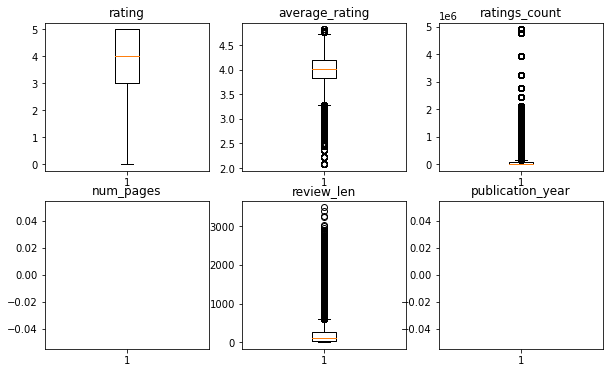

In [51]:
plot = [train.rating, train.average_rating, train.ratings_count, train.num_pages, train.review_len, train.publication_year]
plt.figure(figsize = (10,6))
for i in range(len(plot)):
    plt.subplot(2,3, i+1)
    plt.boxplot(x = plot[i])
    plt.title(plot[i].name)

Generally, outliers play only a minor role for our project: our main subject is the classification of reviews with regard to spoilers, which might be modulated by other features (we will learn about that in the EDA) but we're only secondarily intersted in these interactions. Therefore, outliers will not be removed from the dataframe but we will account for them in the feature standardization. 

In [44]:
train.columns

Index(['user_id', 'time', 'review', 'rating', 'spoiler', 'book_id',
       'review_id', 'genres', 'title', 'description', 'publication_year',
       'publication_month', 'publication_day', 'average_rating',
       'ratings_count', 'num_pages', 'weighted_avg_rating', 'genre',
       'spoiler_dum', 'sentence_labels', 'review_texts', 'raw_text',
       'review_len'],
      dtype='object')

In [ ]:
#Safe the reduced dataframe as HDF5
train_red.to_json('data/train_reduced.json')

In [46]:
#Save the not reduced dataframe as json (HDF5 is not possible for values too large to convert)
train.to_json('data/train_data.json')

#### Rescaling of numeric variables

Data are rescaled using the RobustScaler.
The centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar.

In [28]:
#Select numerica variables
train_num = train.copy().select_dtypes('number')

In [29]:
#Rescale data
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(train_num)
train_num_scaled = pd.DataFrame(scaled_features, index= train_num.index, columns= train_num.columns)

In [40]:
#Rescale reduced data
train_red_num = train_red.copy().select_dtypes('number')
scaled_features_red = scaler.fit_transform(train_red_num)
train_red_num_scaled = pd.DataFrame(scaled_features_red, index= train_red_num.index, columns= train_red_num.columns)

In [30]:
#Isolate the non-numeric variables
train_obj = train.copy().select_dtypes('object', 'datetime')

In [41]:
train_red_obj = train_red.copy().select_dtypes('object', 'datetime')

In [34]:
# Concatenate 
train_scaled = pd.concat([train_obj, train_num_scaled],axis = 1)

In [35]:
train_scaled.head()

,user_id,review,book_id,review_id,genres,title,description,genre,sentence_labels,review_texts,raw_text,time,rating,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_avg_rating,spoiler_dum,review_len
0,c2a49914f29862c29bba7507d6f674bb,"[[0, The plot is good, the characters are good...",12497,3607653ec78471cccf495bd160cdef0c,"{'fiction': 1653, 'mystery, thriller, crime': ...",No Country for Old Men,"In his blistering new novel, Cormac McCarthy r...",fiction,"[0, 0, 0, 0]","['The plot is good, the characters are good, t...",The plot is good the characters are good the s...,0.6979427997992977,0.6000000000000001,0.9599614085865895,0.5454545454545454,0.3333333333333333,0.7481751824817516,0.020884507345792242,0.04625748502994012,0.019874159211150468,0.0,0.02061855670103093
1,a6c7ea6d7767c2e04a6b7856aaabbdf2,"[[0, This book is difficult to define.], [0, (...",9279177,4de61f79cf93354d1bc3c47d362e9ca3,"{'romance': 769, 'fiction': 1075, 'young-adult...",The Lover's Dictionary,"basis, n.\nThere has to be a moment at the beg...",fiction,"[0, 0, 0, 0, 0]","['This book is difficult to define.', ""(And if...","This book is difficult to define ""And if I wer...",0.46688409433015554,1.0,0.9623733719247467,0.0,0.1,0.6605839416058393,0.0071890558838583595,0.03158682634730539,0.006443652488203286,0.0,0.024627720504009167
2,9c9815246338d161800d44b8a6f84f5b,"[[0, Still one of my favourite fantasyseries o...",45107,d5a535c176579e2a00b9819a46482306,"{'fantasy, paranormal': 2098, 'fiction': 310}","Assassin's Apprentice (Farseer Trilogy, #1)",In a faraway land where members of the royal f...,"fantasy, paranormal",[0],['Still one of my favourite fantasyseries of a...,Still one of my favourite fantasyseries of all...,0.9831911690918216,1.0,0.9551374819102749,0.1818181818181818,nan,0.7518248175182479,0.027188451795814975,0.0688622754491018,0.025935726058369187,0.0,0.002290950744558992
3,fffce7dae5ac5e8fb6288d81658ececc,"[[0, DNF at 30 pages.], [0, I seriously debate...",15749186,2593d837196037879e8482342f3d9cf5,"{'fiction': 706, 'young-adult': 665, 'romance'...",To All the Boys I've Loved Before (To All the ...,What if all the crushes you ever had found out...,fiction,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","['DNF at 30 pages.', 'I seriously debated whet...",DNF at pages I seriously debated whether or n...,0.8499749121926743,0.2,0.9643029425952725,0.1818181818181818,0.6333333333333333,0.740875912408759,0.029554395271133488,0.0531437125748503,0.02798832208858508,0.0,0.046105383734249716
4,f8fc32781e4755d75e748bde57bea9a4,"[[0, Better than I expected, having read 2 oth...",11850778,efccf02d73be0cd815d025b46df4ed31,"{'fiction': 50, 'fantasy, paranormal': 26, 'my...",The Chronological Man: The Monster In The Mist,It's 1890 and the citizens of Boston are begin...,fiction,"[0, 0, 0, 0]","['Better than I expected, having read 2 other ...",Better than I expected having read other book...,0.5075263421976919,0.8,0.9623733719247467,0.4545454545454545,0.4666666666666667,0.6094890510948904,0.0002140839045638852,0.020059880239520957,0.00018487634144454752,0.0,0.005441008018327607


In [42]:
train_red_scaled = pd.concat([train_red_num_scaled, train_red_obj],axis = 1)

In [43]:
#Safe the reduced dataframe as json-file
train_red_scaled.to_json('data/train_reduced_scaled.json')

In [36]:
#Save the not reduced dataframe as json.file
train_scaled.to_json('data/train_data_scaled.json')